In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/water-quality-dataset/waterPollution.csv


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import warnings

In [34]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [35]:
path = "/kaggle/input/water-quality-dataset/waterPollution.csv"

In [36]:
data = pd.read_csv(path)

In [37]:
# Inspect data
data.head()

,parameterWaterBodyCategory,observedPropertyDeterminandCode,procedureAnalysedFraction,procedureAnalysedMedia,resultUom,phenomenonTimeReferenceYear,parameterSamplingPeriod,resultMeanValue,waterBodyIdentifier,Country,...,composition_food_organic_waste_percent,composition_glass_percent,composition_metal_percent,composition_other_percent,composition_paper_cardboard_percent,composition_plastic_percent,composition_rubber_leather_percent,composition_wood_percent,composition_yard_garden_green_waste_percent,waste_treatment_recycling_percent
0,RW,CAS_14797-65-0,total,water,mg{NO2}/L,2009,2009-01--2009-12,0.063310,FRDR609,France,...,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,0.0,22.26
1,RW,CAS_14797-65-0,total,water,mg{NO2}/L,2009,2009-01--2009-12,0.046733,FRFR238,France,...,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,0.0,22.26
2,RW,EEA_3164-07-6,total,water,{massRatio},2009,2009-01--2009-12,132.859000,FRFR238,France,...,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,0.0,22.26
3,RW,CAS_14797-55-8,total,water,mg{NO3}/L,2009,2009-01--2009-12,11.578376,FRFR327C,France,...,32.0,10.0,3.0,26.0,20.0,9.0,0.0,0.0,0.0,22.26
4,RW,EEA_3151-01-7,total,water,mmol/L,2009,2009-01--2009-12,0.206800,ES014MSPFES-014-NR-038-000-02-02,Spain,...,49.0,8.0,3.0,14.0,15.0,9.0,0.0,2.0,0.0,16.84


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19893 entries, 0 to 19999
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   parameterWaterBodyCategory                   19893 non-null  int64  
 1   observedPropertyDeterminandCode              19893 non-null  int64  
 2   procedureAnalysedFraction                    19893 non-null  int64  
 3   procedureAnalysedMedia                       19893 non-null  int64  
 4   resultUom                                    19893 non-null  int64  
 5   phenomenonTimeReferenceYear                  19893 non-null  int64  
 6   parameterSamplingPeriod                      19893 non-null  int64  
 7   resultMeanValue                              19893 non-null  float64
 8   waterBodyIdentifier                          19893 non-null  int64  
 9   Country                                      19893 non-null  int64  
 10  Pop

In [38]:
data.describe()

,phenomenonTimeReferenceYear,resultMeanValue,PopulationDensity,TerraMarineProtected_2016_2018,TouristMean_1990_2020,VenueCount,netMigration_2011_2018,droughts_floods_temperature,literacyRate_2010_2018,combustibleRenewables_2009_2014,...,composition_food_organic_waste_percent,composition_glass_percent,composition_metal_percent,composition_other_percent,composition_paper_cardboard_percent,composition_plastic_percent,composition_rubber_leather_percent,composition_wood_percent,composition_yard_garden_green_waste_percent,waste_treatment_recycling_percent
count,20000.000000,20000.000000,19893.000000,19893.000000,1.989300e+04,20000.000000,19893.000000,19893.000000,19893.000000,19893.000000,...,19893.000000,19893.000000,19893.000000,19893.000000,19893.000000,19893.000000,19893.000000,19893.000000,19893.000000,19893.000000
mean,2008.998700,34.444639,149.895102,26.227472,4.919348e+07,0.141400,114206.842878,0.130027,14.859312,4.652609,...,32.166075,7.663619,3.196126,23.519892,18.903705,11.206789,0.159449,2.073875,1.302482,23.312787
std,1.917859,174.643233,75.994558,6.790095,2.469506e+07,1.922314,144682.517527,0.260679,31.565912,3.444092,...,11.326430,3.279468,1.130070,6.551350,4.252571,4.901386,0.731725,3.013117,3.656386,5.958540
min,1991.000000,0.000015,14.548292,3.875411,5.300380e+05,0.000000,-83749.750000,0.000000,0.000000,1.064468,...,12.780000,2.200000,1.380000,0.000000,5.000000,1.450000,0.000000,0.000000,0.000000,0.760000
25%,2008.000000,0.114100,122.299437,23.733280,2.586796e+07,0.000000,21256.750000,0.005718,0.000000,4.363288,...,30.000000,5.440000,3.000000,17.700000,18.900000,9.000000,0.000000,0.000000,0.000000,22.260000
50%,2009.000000,2.000000,122.299437,30.831906,5.094169e+07,0.000000,75808.375000,0.005718,0.000000,4.457840,...,32.000000,10.000000,3.000000,26.000000,20.000000,9.000000,0.000000,0.000000,0.000000,22.260000
75%,2009.000000,10.975625,137.976566,30.831906,7.117635e+07,0.000000,75808.375000,0.032407,0.000000,4.457840,...,32.000000,10.000000,3.000000,26.000000,20.000000,12.400000,0.000000,2.000000,2.700000,27.250000
max,2017.000000,14108.000000,511.475928,38.767234,7.117635e+07,100.000000,582211.000000,0.729194,87.158924,25.982190,...,62.300000,21.400000,9.200000,44.050000,37.830000,22.900000,6.000000,17.210000,30.460000,47.830000


In [39]:
data.isna().sum()

parameterWaterBodyCategory                       0
observedPropertyDeterminandCode                  0
procedureAnalysedFraction                        0
procedureAnalysedMedia                           0
resultUom                                        0
phenomenonTimeReferenceYear                      0
parameterSamplingPeriod                          0
resultMeanValue                                  0
waterBodyIdentifier                              0
Country                                        104
PopulationDensity                              107
TerraMarineProtected_2016_2018                 107
TouristMean_1990_2020                          107
VenueCount                                       0
netMigration_2011_2018                         107
droughts_floods_temperature                    107
literacyRate_2010_2018                         107
combustibleRenewables_2009_2014                107
gdp                                            107
composition_food_organic_waste_

In [40]:
# Handling Missing Values
data.dropna(axis=0, inplace=True)
print(data.isna().sum())

parameterWaterBodyCategory                     0
observedPropertyDeterminandCode                0
procedureAnalysedFraction                      0
procedureAnalysedMedia                         0
resultUom                                      0
phenomenonTimeReferenceYear                    0
parameterSamplingPeriod                        0
resultMeanValue                                0
waterBodyIdentifier                            0
Country                                        0
PopulationDensity                              0
TerraMarineProtected_2016_2018                 0
TouristMean_1990_2020                          0
VenueCount                                     0
netMigration_2011_2018                         0
droughts_floods_temperature                    0
literacyRate_2010_2018                         0
combustibleRenewables_2009_2014                0
gdp                                            0
composition_food_organic_waste_percent         0
composition_glass_pe

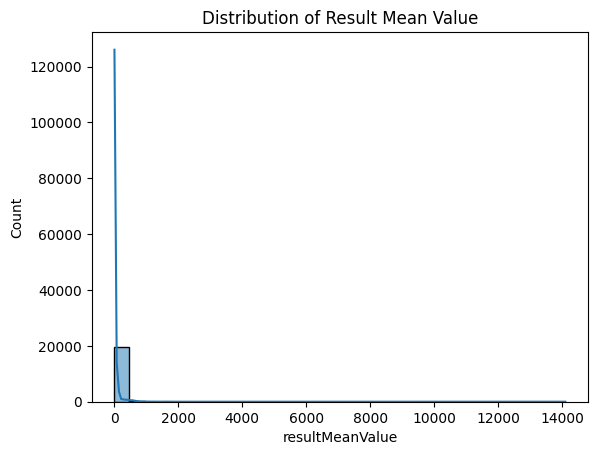

In [41]:
# Data Visualization
sns.histplot(data['resultMeanValue'], bins=30, kde=True)
plt.title('Distribution of Result Mean Value')
plt.show()

In [42]:
# Preprocessing
# Label Encoding for categorical features
columns = ["parameterWaterBodyCategory", "observedPropertyDeterminandCode", "procedureAnalysedFraction",
           "procedureAnalysedMedia", "resultUom", "parameterSamplingPeriod", "waterBodyIdentifier", "Country"]
for col in columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [44]:
# Defining features and target
x = data.drop(["resultMeanValue"], axis=1)
y = data["resultMeanValue"]

In [45]:
# Binarize the target variable
def makeClass(y):
    return ["Dirty" if val > 500 else "Clean" for val in y]

y = makeClass(y)

In [50]:
# Convert target labels to numeric
le_y = LabelEncoder()
y = le_y.fit_transform(y)

In [51]:
# Standarizing Data
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

In [52]:
# Split Dataset (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [53]:
# Modelling ML
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": xg.XGBClassifier(),
    "Random Forest": RandomForestClassifier(),
    "ANN": MLPClassifier(max_iter=1000)
}

In [55]:
# Train and evaluate models
model_performance = {}
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = model.score(x_test, y_test)
    auc_score = roc_auc_score(y_test, y_pred)
    model_performance[name] = {
        "Accuracy": accuracy,
        "AUC Score": auc_score,
        "Classification Report": classification_report(y_test, y_pred, target_names=le_y.classes_)
    }

In [56]:
# Print model performance
for name, metrics in model_performance.items():
    print(f"Model: {name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"AUC Score: {metrics['AUC Score']}")
    print("Classification Report:")
    print(metrics["Classification Report"])
    print("-" * 50)

Model: KNN
Accuracy: 0.9904498617743152
AUC Score: 0.7697833794534763
Classification Report:
              precision    recall  f1-score   support

       Clean       0.99      1.00      1.00      3920
       Dirty       0.74      0.54      0.63        59

    accuracy                           0.99      3979
   macro avg       0.87      0.77      0.81      3979
weighted avg       0.99      0.99      0.99      3979

--------------------------------------------------
Model: Decision Tree
Accuracy: 0.9889419452123649
AUC Score: 0.7940591490833623
Classification Report:
              precision    recall  f1-score   support

       Clean       0.99      0.99      0.99      3920
       Dirty       0.64      0.59      0.61        59

    accuracy                           0.99      3979
   macro avg       0.82      0.79      0.80      3979
weighted avg       0.99      0.99      0.99      3979

--------------------------------------------------
Model: XGBoost
Accuracy: 0.9899472229203318
AUC 

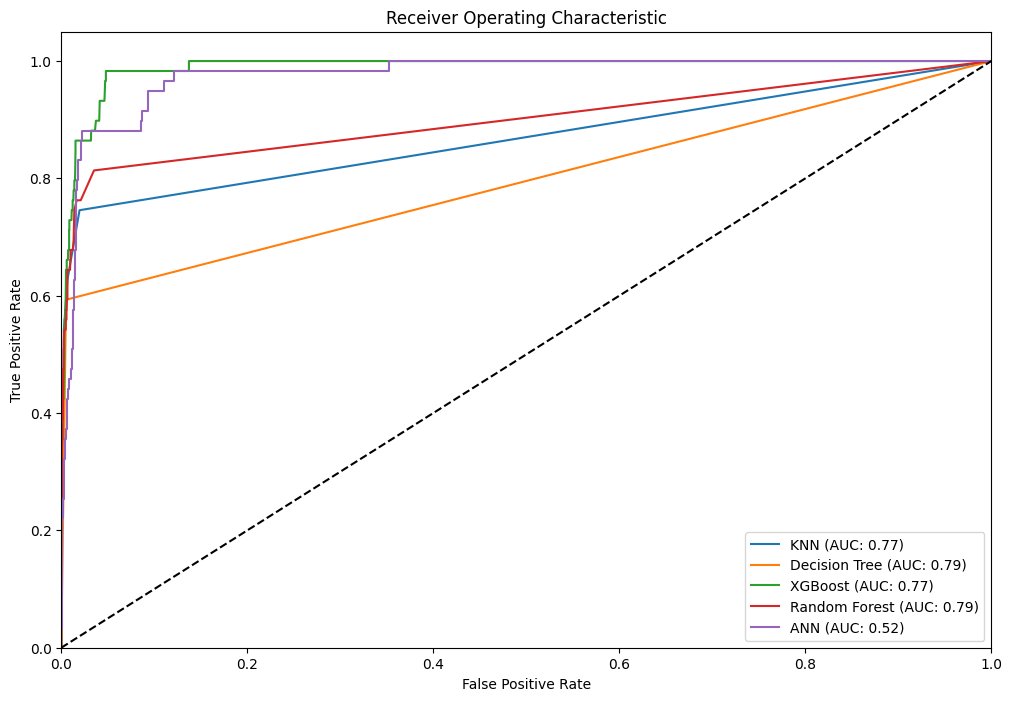

In [59]:
# Plot ROC Curves
plt.figure(figsize=(12, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(x_test)[:, 1]
    else:
        y_score = model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f'{name} (AUC: {model_performance[name]["AUC Score"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

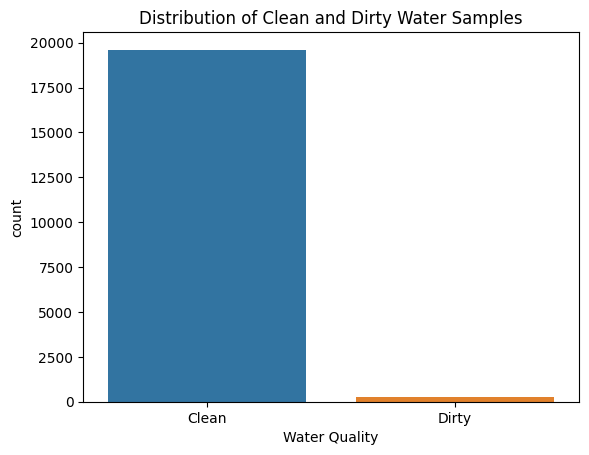

In [60]:
# Conclusion
# Plotting the distribution of Clean vs Dirty water samples
data['Water Quality'] = makeClass(data['resultMeanValue'])
sns.countplot(x='Water Quality', data=data)
plt.title('Distribution of Clean and Dirty Water Samples')
plt.show()

In [61]:
# Determine the best model
best_model_name = max(model_performance, key=lambda k: model_performance[k]['Accuracy'])
print(f"The best model is {best_model_name} with an accuracy of {model_performance[best_model_name]['Accuracy']}")

The best model is KNN with an accuracy of 0.9904498617743152


Accuracy with parameterWaterBodyCategory Feature: 0.9867627345844504
-----------------------------------------------------------------
Accuracy with observedPropertyDeterminandCode Feature: 0.9740281501340483
-----------------------------------------------------------------
Accuracy with procedureAnalysedFraction Feature: 0.9874329758713136
-----------------------------------------------------------------
Accuracy with procedureAnalysedMedia Feature: 0.9874329758713136
-----------------------------------------------------------------
Accuracy with resultUom Feature: 0.9874329758713136
-----------------------------------------------------------------
Accuracy with phenomenonTimeReferenceYear Feature: 0.9849195710455764
-----------------------------------------------------------------
Accuracy with parameterSamplingPeriod Feature: 0.9850871313672922
-----------------------------------------------------------------
Accuracy with waterBodyIdentifier Feature: 0.99078418230563
--------------

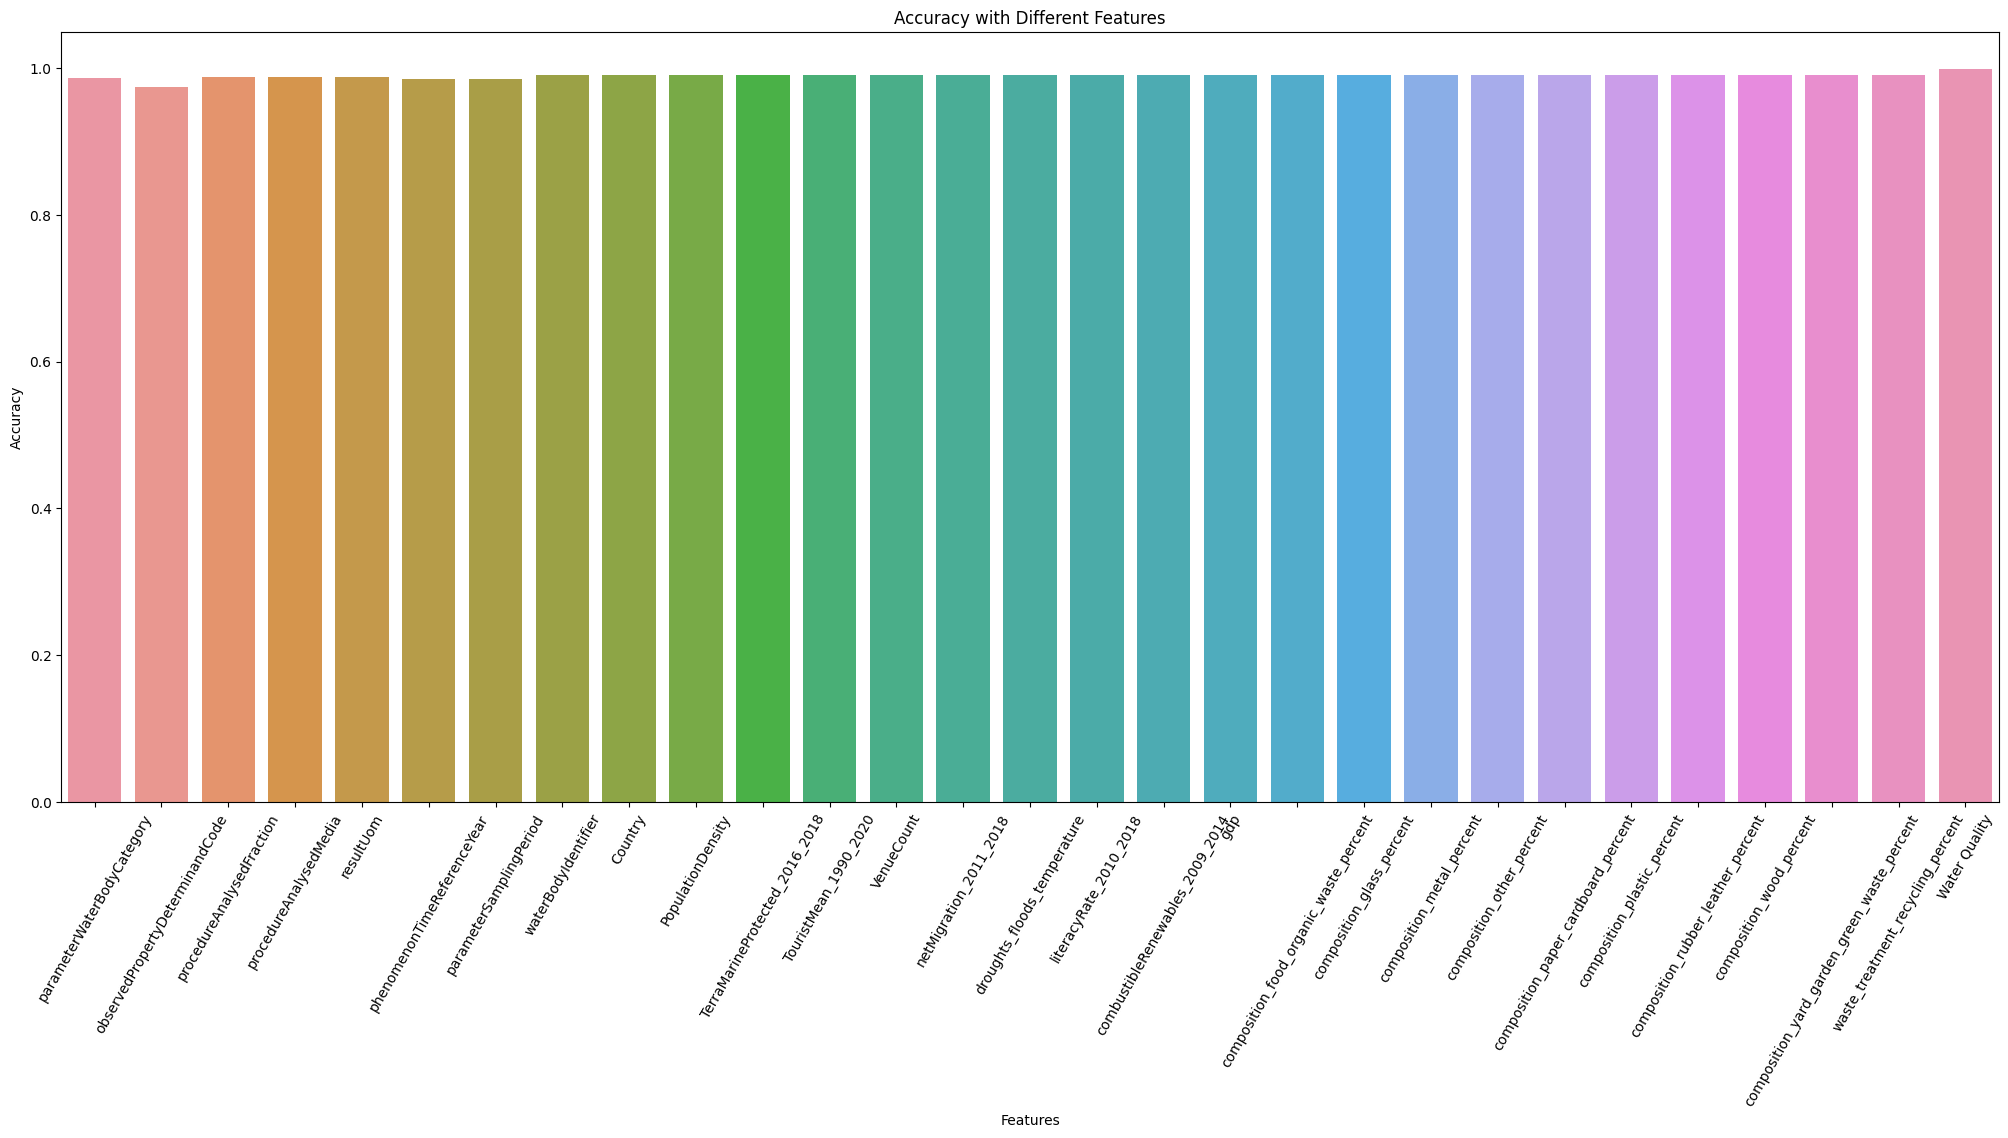

In [66]:
# Plotting feature importance
model = KNeighborsClassifier()

y = data["resultMeanValue"].values
x = data.drop(["resultMeanValue"], axis=1)

def makeClass(y):
    y = ["Dirty" if x > 500 else "Clean" for x in y]
    return y


def fitData(x, y, model, columns):
    a = x[columns]
    x_train, x_test, y_train, y_test = train_test_split(a, y, test_size=0.3, random_state=42)
    y_train, y_test = makeClass(y_train), makeClass(y_test)
    
    # Encode categorical variables
    encoder = LabelEncoder()
    for col in a.select_dtypes(include=['object']).columns:
        x_train[col] = encoder.fit_transform(x_train[col])
        x_test[col] = encoder.transform(x_test[col])
    
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    model.fit(x_train, y_train)
    return model.score(x_test, y_test)

usedCols = list()
scores = list()
for col in x.columns:
    usedCols.append(col)
    score = fitData(x, y, model, usedCols)
    scores.append(score)
    print(f"Accuracy with {col} Feature: {score}")
    print("-" * 65)

plt.figure(figsize=(25, 10))
sns.barplot(x=usedCols, y=scores)
plt.xticks(rotation=60)
plt.title('Accuracy with Different Features')
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.show()
